# Global Attention and word embedding demonstration

This will briefly cover embedding and attention layer. Lemmatization and Stemming are not present here.

In [9]:
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model
import numpy as np
import pandas as pd

## Dataset import

We import the amazon_cells_labelled csv dataset. Available <a href="https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences">here</a>

In [10]:
df = pd.read_csv("amazon_cells_labelled.txt", header=None, delimiter="\\t")
len(df) #1000 samples

c:\users\leximus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


1000

## Generating tokens

In [21]:
#We use a one hot encoder Each sentence is converted to a token encoding.
#In other term, we replace all "King" by the same numerical value.
t = Tokenizer()
t.fit_on_texts(df[0])
text_matrix = t.texts_to_sequences(df[0])
print(df[0][0])
print("converted to:")
print(text_matrix[0])

So there is no way for me to plug it in here in the US unless I go by a converter.
converted to:
[33, 117, 5, 53, 214, 11, 47, 8, 155, 4, 19, 337, 19, 1, 546, 416, 2, 241, 190, 6, 812]


In this case, 33 is equals to "So".

In [24]:
t.index_word[33]

'so'

We need all our input to have the same size. In this case, we look for the longest sentence.

In [26]:
s_length = 0
for i in range(len(text_matrix)):
    s_length = max(len(text_matrix[i]), s_length)
print("The longest sentence is composed of "+str(s_length)+" tokens.")

The longest sentence is composed of 30 tokens.


## Padding

If the longest sentence is made of 30 tokens, there are some which are smaller. We will thus add a "0" (not used in the dictionnary) to signify "empty token" there.

This will help us to complete the vector of the other sizes

In [29]:
from keras.preprocessing.sequence import pad_sequences

print(text_matrix[0])

text_pad = pad_sequences(text_matrix, maxlen=s_length, padding='post')

print(text_pad[0])

[33, 117, 5, 53, 214, 11, 47, 8, 155, 4, 19, 337, 19, 1, 546, 416, 2, 241, 190, 6, 812]
[ 33 117   5  53 214  11  47   8 155   4  19 337  19   1 546 416   2 241
 190   6 812   0   0   0   0   0   0   0   0   0]


As you can see above, a bunch of "0" have been added to the vector to get an array of 32 elements.

In [36]:
#We know look for the size of our dictionnary, since we need it to configure the embedding layer.
nb_tokens = len(t.word_index) + 1

In [67]:
latent_dim = 32 #What is the size of the abstract representation we want to represent each word?
#Every word can be represented by has much number you want.
#Some of this neuron might generate the gender (King = 0 vs Queen = 1),
# another the social status (King = 1 vs fool = 0), etc...
#This is a hidden layer where the network will try to capture the differences.

inp = Input(shape=(s_length,)) #We create a vector of 32 dimensions as input


#input_dim : Size of the vocabulary dict
#input_length : Size of the sentences.
#output_dim : the latent dim variable, the size of the representation.
x = Embedding(input_dim = nb_tokens, \
              input_length = s_length, \
              output_dim = latent_dim,\
              embeddings_regularizer = keras.regularizers.l2(.001))(inp) #Regularization to help learning

x = LSTM(64, dropout = 0.2, recurrent_dropout = 0.2)(x) #A simplement LSTM network made of 64 cells

out = Dense(1, activation='sigmoid')(x) #Our output neuron for the sentiment analysis.

model = Model(inp, out)

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 30)                0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 30, 32)            60128     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 85,025
Trainable params: 85,025
Non-trainable params: 0
_________________________________________________________________


In [69]:
#We build and fit the model

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

train_no_attention_history = model.fit(x = text_pad, y = df[1], \
                          batch_size = 64, epochs = 15, \
                          verbose = 1, shuffle = True, \
                          validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 3s 4ms/step - loss: 0.7305 - acc: 0.4713 - val_loss: 0.7170 - val_acc: 0.4550
Epoch 2/15
800/800 [==============================] - 1s 1ms/step - loss: 0.7076 - acc: 0.5112 - val_loss: 0.7032 - val_acc: 0.4550
Epoch 3/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6982 - acc: 0.5112 - val_loss: 0.6998 - val_acc: 0.4550
Epoch 4/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6941 - acc: 0.5112 - val_loss: 0.6961 - val_acc: 0.4550
Epoch 5/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6933 - acc: 0.5112 - val_loss: 0.6944 - val_acc: 0.4550
Epoch 6/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6929 - acc: 0.5275 - val_loss: 0.6943 - val_acc: 0.4550
Epoch 7/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6927 - acc: 0.5312 - val_loss: 0.6957 - val_acc: 0.4550
Epoch 8/15
800/800 [==========

In [50]:
import matplotlib.pyplot as plt

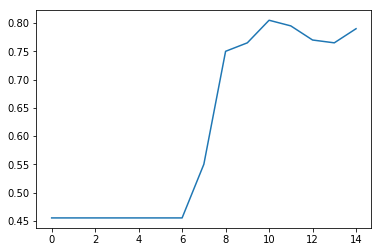

In [70]:
plt.plot(train_no_attention_history.history["val_acc"])

In [53]:
from keras.layers import Layer
import keras.backend as K

class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.weight = self.add_weight(name="watt", shape=(input_shape[-1], 1), initializer="normal")
        self.bias = self.add_weight(name="batt", shape=(input_shape[1], 1), initializer="zeros")        
        super(Attention, self).build(input_shape)

    def call(self,x):
        att = K.expand_dims(K.softmax(K.squeeze(K.tanh(K.dot(x,self.weight) + self.bias), axis=-1)), axis=-1)
        return K.sum(x*att, axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(Attention,self).get_config()

In [72]:
inp = Input(shape=(s_length,))
x = Embedding(input_dim = nb_tokens, \
              input_length = s_length, \
              output_dim = latent_dim,\
              embeddings_regularizer = keras.regularizers.l2(.001))(inp)

x = LSTM(64, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2)(x)
x = Attention()(x)

out = Dense(1, activation='sigmoid')(x) #Our output neuron for the sentiment analysis.

model = Model(inp, out)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 30)                0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 30, 32)            60128     
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 64)            24832     
_________________________________________________________________
attention_9 (Attention)      (None, 64)                94        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 85,119
Trainable params: 85,119
Non-trainable params: 0
_________________________________________________________________


Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 4s 5ms/step - loss: 0.7305 - acc: 0.5075 - val_loss: 0.7185 - val_acc: 0.4550
Epoch 2/15
800/800 [==============================] - 1s 1ms/step - loss: 0.7077 - acc: 0.5150 - val_loss: 0.7041 - val_acc: 0.4550
Epoch 3/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6960 - acc: 0.5162 - val_loss: 0.7005 - val_acc: 0.4600
Epoch 4/15
800/800 [==============================] - 1s 1ms/step - loss: 0.6755 - acc: 0.5950 - val_loss: 0.6486 - val_acc: 0.6600
Epoch 5/15
800/800 [==============================] - 1s 1ms/step - loss: 0.4699 - acc: 0.8013 - val_loss: 0.5786 - val_acc: 0.7450
Epoch 6/15
800/800 [==============================] - 1s 1ms/step - loss: 0.3029 - acc: 0.8962 - val_loss: 0.7135 - val_acc: 0.7300
Epoch 7/15
800/800 [==============================] - 1s 1ms/step - loss: 0.2250 - acc: 0.9300 - val_loss: 0.6067 - val_acc: 0.7550
Epoch 8/15
800/800 [==========

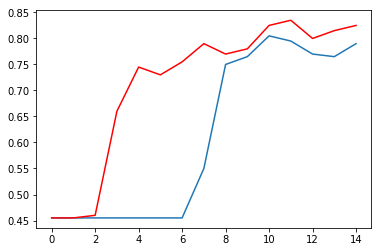

In [73]:
train_attention_history = model.fit(x = text_pad, y = df[1], \
                          batch_size = 64, epochs = 15, \
                          verbose = 1, shuffle = True, \
                          validation_split=0.2)
plt.plot(train_no_attention_history.history["val_acc"])
plt.plot(train_attention_history.history["val_acc"], color="red")

We see how the model with Attention Layer (in red) captured faster the distribution and achieved even better result.